
# Triage Efficiency

(how long it takes to triage the scene) What record in the FRVRS log is there that shows that the scene triage is complete?


## 0. Importing libraries and still patients data frame

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get the time that all still patients are engaged
if nu.pickle_exists('still_patients_df'):
    still_patients_df = nu.load_object('still_patients_df')
    print(still_patients_df.shape)
    df = still_patients_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(2996, 11)


,2475,2845,790,873
logger_version,1.3,1.0,1.3,1.0
session_uuid,d8e74818-ecc1-4f24-87aa-5dd9facfe20f,f3447210-99fa-4990-8c1b-747a1e916e79,3e4e23e4-ce9e-44b7-9a1e-6e2923b33123,445ceb23-1514-4490-9aa6-f2fc55b5d28e
scene_index,2,0,2,1
is_scene_aborted,False,False,False,False
scene_type,Normal,Normal,Normal,Normal
patient_id,Lily_7 Root,Gary_1 Root,Gary_1 Root,Gary_1 Root
first_notice,368937,4495,328197,19698
first_action,375634.0,NaN,333690.0,30566.0
first_engagement,393407.0,NaN,421400.0,69904.0
notice_to_engagement,24470.0,NaN,93203.0,50206.0



We are measuring the time it takes to triage a scen. The grey-scale visualizations are from _First Responder Accuracy Using SALT during Mass-casualty Incident Simulation_, original research by Christopher W.C. Lee, MD, BASc; Shelley L. McLeod, MSc, BSc Hons; Kristine Van Aarsen, MSc, BSc; Michelle Klingel, MSc, BSc; Jeffrey M. Franc, MD, MSc, FCFP(EM), Dip. Sport Med., EMDM; and Michael B. Peddle, MD, FRCP(C), Dip. Sport Med.


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_time_to_triage_completion.png" />

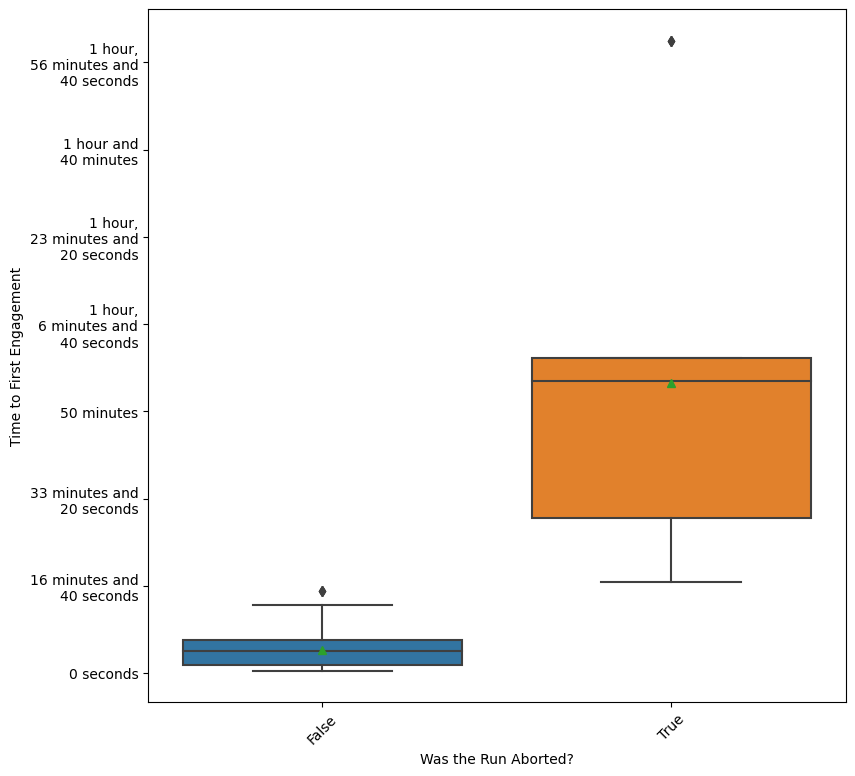

In [4]:

nu.plot_grouped_box_and_whiskers(still_patients_df, 'is_scene_aborted', 'first_engagement', 'Was the Run Aborted?', 'Time to First Engagement', transformer_name='min')

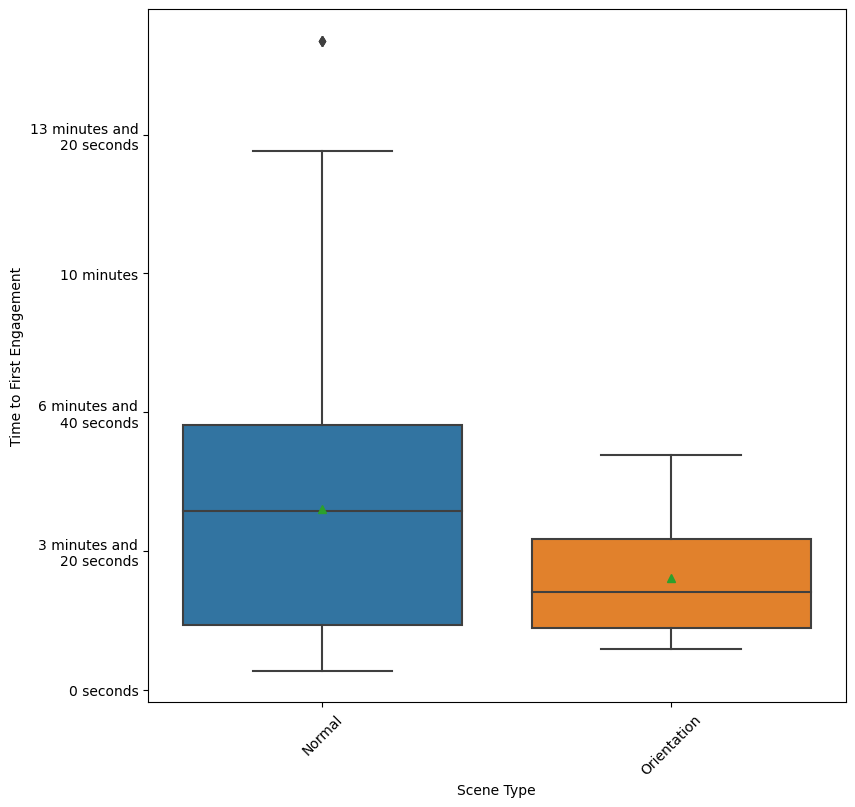

In [5]:

mask_series = (still_patients_df.is_scene_aborted == False)
nu.plot_grouped_box_and_whiskers(still_patients_df[mask_series], 'scene_type', 'first_engagement', 'Scene Type', 'Time to First Engagement', transformer_name='min')

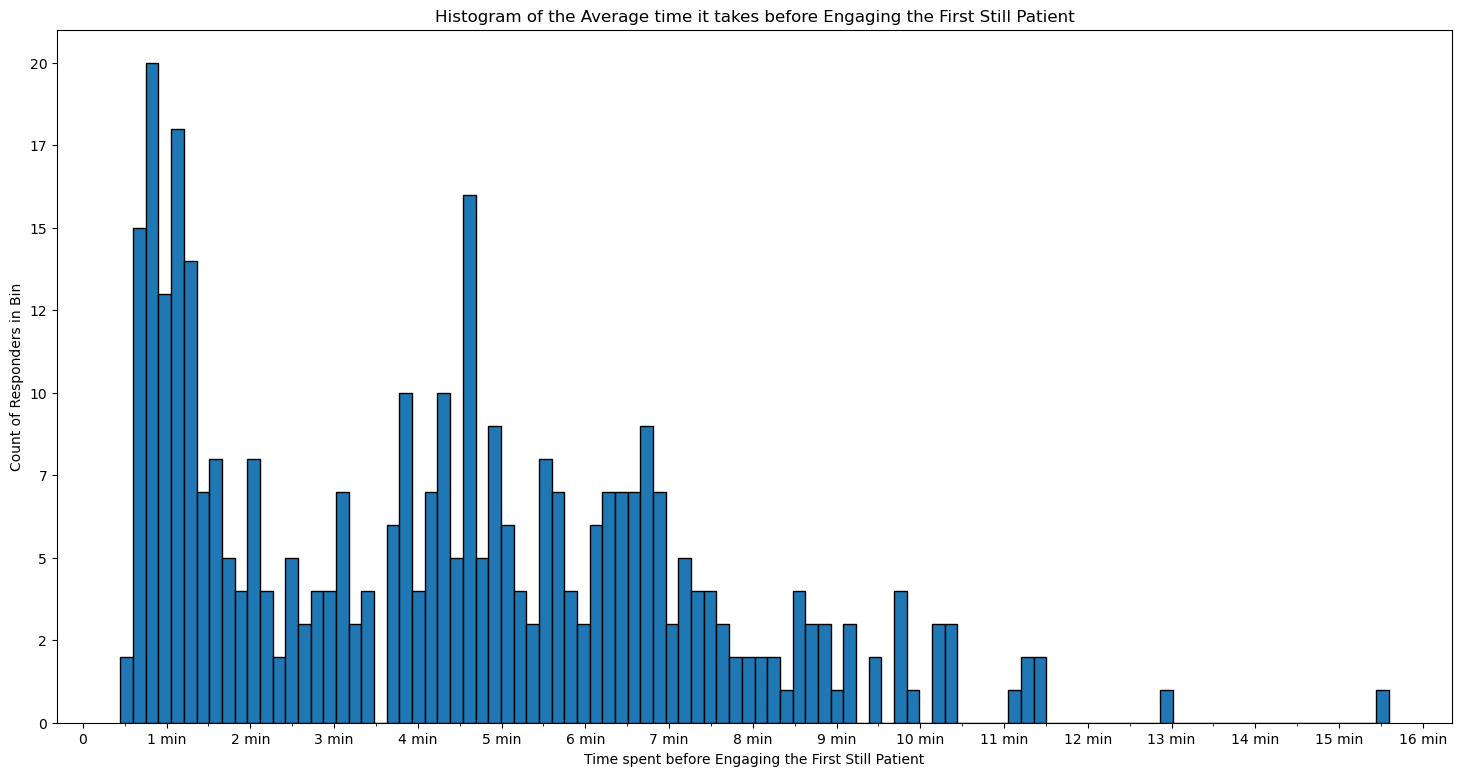

In [7]:

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (min_first_engagement_df.min_scene_type == 'Normal') & (min_first_engagement_df.min_is_scene_aborted == False)
df = min_first_engagement_df[mask_series]

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: nu.format_timedelta(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

# Histogram of the time that it takes to triage the scene (assuming a still patient is the first engaged)
xlabel = 'Time spent before Engaging the First Still Patient'
title = 'Histogram of the Average time it takes before Engaging the First Still Patient'
ylabel = 'Count of Responders in Bin'
ax = nu.plot_histogram(df, 'min_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True)

In [8]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'min_first_engagement'
]

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (min_first_engagement_df.min_scene_type == 'Normal') & (min_first_engagement_df.min_is_scene_aborted == False)
df = min_first_engagement_df[mask_series][columns_list]
nu.show_time_statistics(df, columns_list)

,mean,mode,median,SD,min,25%,50%,75%,max
min_first_engagement,4:20,27,4:17,±2:51,27,1:33,4:17,6:21,15:35


In [7]:

def show_long_runs(df, column_name, milliseconds, delta_fn, description):
    delta = delta_fn(milliseconds)
    print(f'\nThese files have {description} than {delta}:')
    mask_series = (df[column_name] > milliseconds)
    session_uuid_list = df[mask_series].session_uuid.tolist()
    mask_series = frvrs_logs_df.session_uuid.isin(session_uuid_list)
    logs_folder = '../data/logs'
    import csv
    from datetime import datetime
    for old_file_name in frvrs_logs_df[mask_series].file_name.unique():
        old_file_path = os.path.join(logs_folder, old_file_name)
        with open(old_file_path, 'r') as f:
            reader = csv.reader(f, delimiter=',', quotechar='"')
            for values_list in reader:
                date_str = values_list[2]
                break
            try: date_obj = datetime.strptime(date_str, '%m/%d/%Y %H:%M')
            except ValueError: date_obj = datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p')
            new_file_name = date_obj.strftime('%y.%m.%d.%H%M.csv')
            new_sub_directory = old_file_name.split('/')[0]
            new_file_path = new_sub_directory + '/' + new_file_name
            print(f'{old_file_name} (or {new_file_path})')

In [8]:

# We would never have someone in the headset for 2 hours.
# Any runs longer than that 16 minutes and 40 seconds was probably an instance
# of someone taking off the headset and setting it on the ground.
# 1 second = 1000 milliseconds; 1 minute = 60 seconds
sixteen_minutes_forty_seconds = 1_000 * 60 * 16 + 1_000 * 40
delta_fn = lambda x: humanize.precisedelta(timedelta(milliseconds=x))
description = 'runs longer'
show_long_runs(min_first_engagement_df, 'min_first_engagement', sixteen_minutes_forty_seconds, delta_fn, description)


These files have runs longer than 16 minutes and 40 seconds:
v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a270.csv (or v.1.0/23.05.16.1459.csv)
v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv (or v.1.0/23.05.16.1615.csv)
v.1.0/clean-9d142377-69d6-4622-958d-a29a6a0a0d21.csv (or v.1.0/23.05.09.0810.csv)
v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa46.csv (or v.1.0/23.06.12.1430.csv)


In [9]:

# The long one was probably taking off the headset and leaving it on while going to lunch.
# Can you tell me which files have the unusually long durations? Anything over 50 minutes is bogus.
# 1 second = 1000 milliseconds; 1 minute = 60 seconds
fifty_minutes = 1_000 * 60 * 50
delta_fn = lambda x: humanize.precisedelta(timedelta(milliseconds=x))
description = 'runs longer'
show_long_runs(min_first_engagement_df, 'min_first_engagement', fifty_minutes, delta_fn, description)


These files have runs longer than 50 minutes:
v.1.0/Clean 06574b6f-ab02-432c-9a65-7b031218a270.csv (or v.1.0/23.05.16.1459.csv)
v.1.0/Clean 724fdf45-3165-43b8-b9ca-dc07102d2886.csv (or v.1.0/23.05.16.1615.csv)
v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa46.csv (or v.1.0/23.06.12.1430.csv)
